<a href="https://colab.research.google.com/github/Hamza-Ali0237/PyTorch-Image-Classification-Projects/blob/main/PyTorch-FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 40.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [23]:
# Import Libraries
import torch
from torch import nn
import torchvision
import torchmetrics as tm
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
# Download FashionMNIST Dataset
train_dataset = torchvision.datasets.FashionMNIST(
    root = './data',
    train = True,
    download = True,
    transform = transform
)

print("Total Classes: ", len(train_dataset.classes))

test_dataset = torchvision.datasets.FashionMNIST(
    root = './data',
    train = False,
    download = True,
    transform = transform
)

# Load Data
train_dl = DataLoader(train_dataset, batch_size = 32, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size = 64, shuffle = False)

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.88MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 169kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.16MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 22.9MB/s]

Total Classes:  10


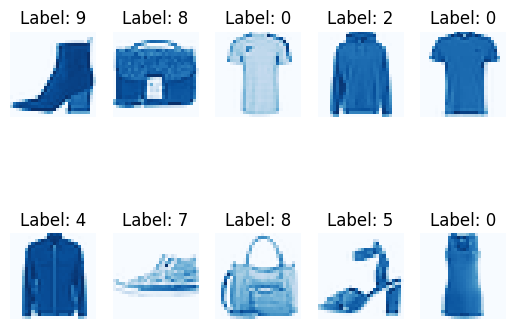

In [5]:
# Display Training Images
data_iter = iter(train_dl)
imgs, lbls = next(data_iter)

for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(imgs[i].squeeze(), cmap = "Blues")
  plt.title(f'Label: {lbls[i].item()}')
  plt.axis('off')
plt.show()

In [6]:
# Define Convolutional Neural Network
class CNN(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()

    self.c1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.relu1 = nn.ReLU()
    self.mp1 = nn.MaxPool2d(kernel_size=2)

    self.c2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.relu2 = nn.ReLU()
    self.mp2 = nn.MaxPool2d(kernel_size = 2)

    self.drop = nn.Dropout(0.3)
    self.flat = nn.Flatten()
    self.cls = nn.Linear(64*7*7, num_classes)

  def forward(self, x):
    x = self.c1(x)
    x = self.bn1(x)
    x = self.relu1(x)
    x = self.mp1(x)

    x = self.c2(x)
    x = self.bn2(x)
    x = self.relu2(x)
    x = self.mp2(x)

    x = self.drop(x)
    x = self.flat(x)
    x = self.cls(x)

    return x

In [7]:
# Set GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
# Initialize Model
cnn = CNN(num_classes=10).to(device)

In [16]:
# Define Loss Function and Optimizer
lr = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr = lr)

# Define Learning Rate Scheduler
step_size = 5 # Change LR After Every 5 Epochs
gamma = 0.5 # Reduce LR By 50% After Every Step
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = step_size, gamma = gamma)

In [17]:
# Training Loop
train_loss = []
val_loss = []
lr_history = []
epochs = 25

for epoch in range(epochs):
  cnn.train()
  epoch_loss = 0.0

  for images, labels in train_dl:
    images, labels = images.to(device), labels.to(device)
    # print(labels.shape, labels[:5])
    optimizer.zero_grad()
    outputs = cnn(images)
    loss = criterion(outputs, labels)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(cnn.parameters(), max_norm=5.0) # Limits Gradient Norm To Avoid Explosion
    # print(cnn.cls.weight.grad.abs().mean().item())
    optimizer.step()
    epoch_loss += loss.item()

  epoch_loss = epoch_loss / len(train_dl)
  train_loss.append(epoch_loss)

  # Validation Loop
  cnn.eval()
  running_val_loss = 0.0

  with torch.no_grad():
    for images, labels in test_dl:
      images, labels = images.to(device), labels.to(device)
      outputs = cnn(images)
      loss = criterion(outputs, labels)
      running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(test_dl)
    val_loss.append(avg_val_loss)

  current_lr = optimizer.param_groups[0]['lr']

  print(f'Epoch [{epoch+1}/{epochs}], Current LR: {current_lr}, Training Loss: {epoch_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

  # Step The LR Scheduler
  scheduler.step()

Epoch [1/25], Current LR: 0.001, Training Loss: 0.1637, Validation Loss: 0.2401
Epoch [2/25], Current LR: 0.001, Training Loss: 0.1620, Validation Loss: 0.2284
Epoch [3/25], Current LR: 0.001, Training Loss: 0.1618, Validation Loss: 0.2347
Epoch [4/25], Current LR: 0.001, Training Loss: 0.1570, Validation Loss: 0.2289
Epoch [5/25], Current LR: 0.001, Training Loss: 0.1528, Validation Loss: 0.2239
Epoch [6/25], Current LR: 0.0005, Training Loss: 0.1304, Validation Loss: 0.2272
Epoch [7/25], Current LR: 0.0005, Training Loss: 0.1214, Validation Loss: 0.2306
Epoch [8/25], Current LR: 0.0005, Training Loss: 0.1219, Validation Loss: 0.2251
Epoch [9/25], Current LR: 0.0005, Training Loss: 0.1170, Validation Loss: 0.2244
Epoch [10/25], Current LR: 0.0005, Training Loss: 0.1154, Validation Loss: 0.2372
Epoch [11/25], Current LR: 0.00025, Training Loss: 0.1044, Validation Loss: 0.2279
Epoch [12/25], Current LR: 0.00025, Training Loss: 0.1017, Validation Loss: 0.2313
Epoch [13/25], Current LR: 0

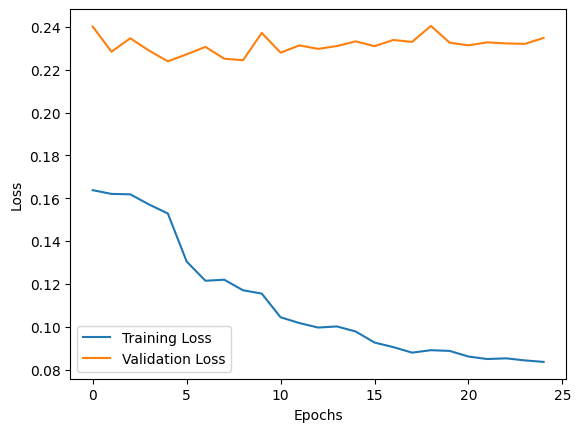

In [18]:
# Plot Learning Curves
plt.plot(train_loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

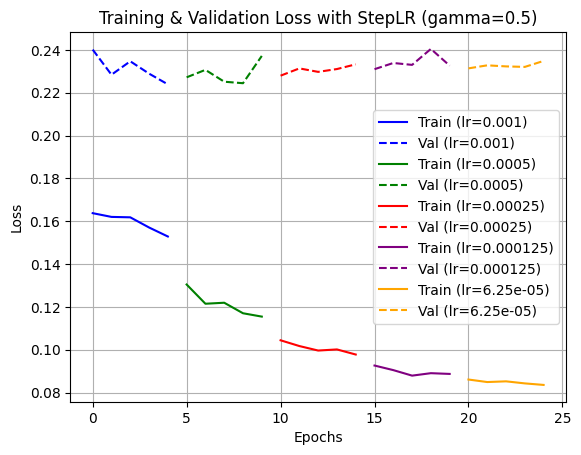

In [19]:
# Color-code The Learning Curves

lr_schedule = [
    (0.001, 5),
    (0.0005, 5),
    (0.00025, 5),
    (0.000125, 5),
    (0.0000625, 5)
]

colors = ['blue', 'green', 'red', 'purple', 'orange']

epoch_start = 0
for (lr, num_epochs), color in zip(lr_schedule, colors):
    epoch_end = epoch_start + num_epochs

    plt.plot(
        range(epoch_start, epoch_end),
        train_loss[epoch_start:epoch_end],
        color=color,
        label=f'Train (lr={lr})'
    )

    plt.plot(
        range(epoch_start, epoch_end),
        val_loss[epoch_start:epoch_end],
        color=color,
        linestyle='--',
        label=f'Val (lr={lr})'
    )

    epoch_start = epoch_end

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss with StepLR (gamma=0.5)')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Define Evaluation Metrics
accuracy = tm.Accuracy(
    task = "multiclass",
    num_classes = 10,
    average = "macro"
).to(device)

precision = tm.Precision(
    task = "multiclass",
    num_classes = 10,
    average = "macro"
).to(device)

recall = tm.Recall(
    task = "multiclass",
    num_classes = 10,
    average = "macro"
).to(device)

In [24]:
# Initialize Confusion Matrix
confusion_matrix = tm.ConfusionMatrix(
    task = "Multiclass",
    num_classes = 10
).to(device)

In [25]:
# Evaluate Model On Test Set
cnn.eval()

with torch.no_grad():
  for images, labels in test_dl:
    images, labels = images.to(device), labels.to(device)
    output = cnn(images)
    predictions = torch.argmax(output, dim=1)

    accuracy(predictions, labels)
    precision(predictions, labels)
    recall(predictions, labels)

    confusion_matrix(predictions, labels)

accuracy_score = accuracy.compute()
precision_score = precision.compute()
recall_score = recall.compute()

print(f'Accuracy: {accuracy_score:.4f}')
print(f'Precision: {precision_score:.4f}')
print(f'Recall: {recall_score:.4f}')

Accuracy: 0.9286
Precision: 0.9283
Recall: 0.9286


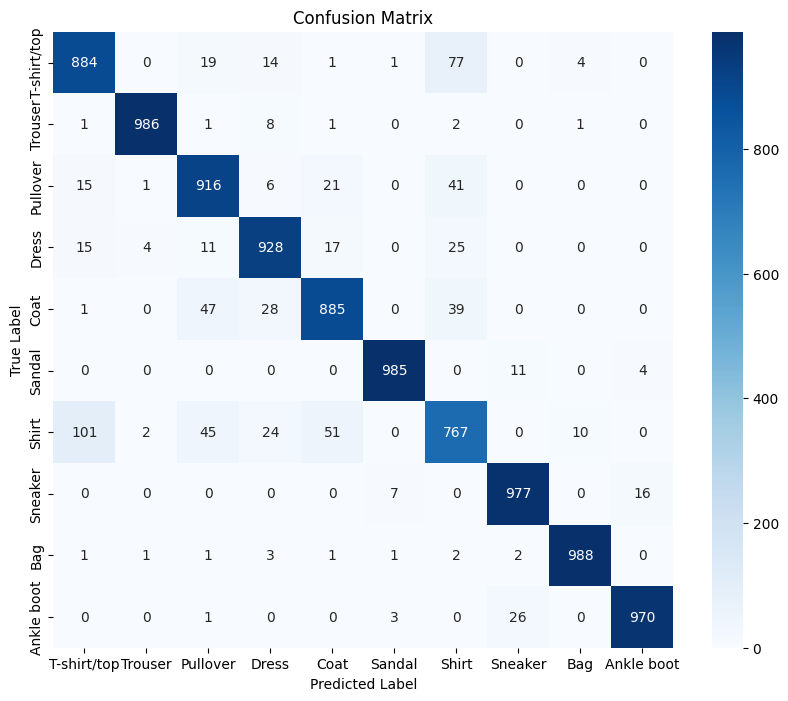

In [26]:
# Compute & Plot Confusion Matrix
cm = confusion_matrix.compute().cpu().numpy()

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()